# Preprocessing

In [1]:
#load all dataset
import glob
import pandas as pd
import datetime
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

t1 = datetime.datetime.now()
df_dic = dict()
file_names = glob.glob("*.csv")
for file_name in file_names:
    df_dic[file_name] = pd.read_csv(file_name)

t2 = datetime.datetime.now()
print('Running time is %d seconds' %((t2-t1).seconds))

Running time is 255 seconds


In [2]:
t1 = datetime.datetime.now()
xls = pd.ExcelFile('MetaData_Tables.xlsx')
df_match = {}
df_all = {}
app = {}
for j in range(1,22):
    if j ==14: #no data from house 14, so skip it
        continue
    else:
        df_match["sheet%d"%j] = pd.read_excel(xls, sheetname='House '+str(j))
        if df_match["sheet%d"%j]['Aggregate'].str.contains('Washing Machine').any():
            df_1 = df_dic['RAW_House_'+str(j)+'_Part1.csv']
            df_2 = df_dic['RAW_House_'+str(j)+'_Part2.csv']
            frames = [df_1,df_2]
            df_all["House%d"%j]= pd.concat(frames)
            df_all["House%d"%j] = df_all["House%d"%j].sort_values(by='Time').reindex()
            df_all["House%d"%j]['datetime'] = pd.to_datetime(df_all["House%d"%j]['Time'])
            df_all["House%d"%j] = df_all["House%d"%j].set_index('datetime')
            df_all["House%d"%j] = df_all["House%d"%j][~df_all["House%d"%j].index.duplicated(keep='first')]
            #find out the appliance number for washing machine
            WM = df_match["sheet%d"%j][df_match["sheet%d"%j]['Aggregate'].str.match('Washing Machine')].index[0]+1 
            app["House%d"%j] = df_all["House%d"%j]['Appliance%d'%WM]
        
t2 = datetime.datetime.now()
print('Running time is %d seconds' %((t2-t1).seconds))

Running time is 321 seconds


# Cycle finding and feature extraction

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
GMM = GaussianMixture(n_components=2)

In [4]:
def convolution_filter():
    conv_filter = np.array([0] * 10 + list(range(40)) + [0] * 10)
    conv_filter = conv_filter - conv_filter.mean()
    
    return conv_filter

In [5]:
def results(series,high_duration,series_conv, Y_):
    mean = [series.mean()]
    std = [series.std()]
    max_value = [series.max()]
    median_value = [series.median()]
    h_duration = [high_duration.seconds]
    series_conv_max = [series_conv.max()]
    series_conv_max_time = np.argmax(series_conv)
    related_time = [(series_conv_max_time - series.index[0]).seconds] #find out when the highest value exists
    GMM.fit(series.values.reshape(-1, 1)) #use 2 GMMs to fit its power histogram
    GMM_mean = GMM.means_[:,0]
    GMM_mean = np.sort(GMM_mean)
    GMM_mean_1 = [GMM_mean[0]]
    GMM_mean_2 = [GMM_mean[1]]
    GMM_std = np.sqrt(GMM.covariances_)[:,0,0]
    GMM_std = np.sort(GMM_std)
    GMM_std_1 = [GMM_std[0]]
    GMM_std_2 = [GMM_std[1]]
    
    return [mean+std+max_value+median_value+series_conv_max+
            GMM_mean_1+GMM_mean_2+GMM_std_1+GMM_std_2+h_duration+related_time+Y_]

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest

def OCSVM_IF_GN(X_normal, X_GN, number):
    f1_svm = []
    f1_IF = []
    num = []
    X_normal_ = np.asarray(X_normal)
    np.random.shuffle(X_normal_)
    for j in range(0,1000,50):
        normal_data = X_normal_[:round(0.5*X_normal_.shape[0])][:,:-1]
        normal_label = X_normal_[:round(0.5*X_normal_.shape[0])][:,-1]
        normal_test = X_normal_[-round(0.25*X_normal_.shape[0]):]
        scaler = StandardScaler()
        X_normal_std = scaler.fit_transform(normal_data)
        clf = svm.OneClassSVM(kernel = 'rbf', nu=0.1)
        clf_IF = IsolationForest()
        clf.fit(X_normal_std, normal_label)
        clf_IF.fit(X_normal_std, normal_label)

        X_abnormal_ = np.asarray(X_GN[j])
        np.random.shuffle(X_abnormal_)
        abnormal_test = X_abnormal_[:round(0.25*X_abnormal_.shape[0])]
        test = np.concatenate((normal_test,abnormal_test),axis = 0)
        np.random.shuffle(test)
        X_test = scaler.transform(test[:,:-1])
        y_test = test[:,-1]
        y_true = y_test
        y_pred_svm = clf.predict(X_test)
        y_pred_IF = clf_IF.predict(X_test)
        f1 = f1_score(y_true,y_pred_svm,average = 'micro')
        f2 = f1_score(y_true,y_pred_IF,average = 'micro')
        f1_svm.append(f1)
        f1_IF.append(f2)
        num.append(j)

    fig,ax = plt.subplots()
    ax.plot(num,f1_svm, label = 'One-Class SVM')
    ax.plot(num,f1_IF, label = 'IsolationForest')
    ax.set_xlabel('Standard deviation')
    ax.set_ylabel('F1 score')
    ax.set_title('House%d OCSVM vs IF(Varying GN)'%number)
    ax.legend()

    return plt.show()

In [7]:
def OCSVM_IF_TD(X_normal, X_TD, number):
    f1_svm = []
    f1_IF = []
    num = []
    X_normal_ = np.asarray(X_normal)
    for TD in range(10,110,10):
        np.random.shuffle(X_normal_)
        normal_data = X_normal_[:round(0.5*X_normal_.shape[0])][:,:-1]
        normal_label = X_normal_[:round(0.5*X_normal_.shape[0])][:,-1]
        normal_test = X_normal_[-round(0.25*X_normal_.shape[0]):]
        scaler = StandardScaler()
        X_normal_std = scaler.fit_transform(normal_data)
        clf = svm.OneClassSVM(kernel = 'rbf', nu=0.1)
        clf_IF = IsolationForest()
        clf.fit(X_normal_std, normal_label)
        clf_IF.fit(X_normal_std, normal_label)

        X_abnormal_ = np.asarray(X_TD[TD])
        np.random.shuffle(X_abnormal_)
        abnormal_test = X_abnormal_[:round(0.25*X_abnormal_.shape[0])]
        test = np.concatenate((normal_test,abnormal_test),axis = 0)
        np.random.shuffle(test)
        X_test = scaler.transform(test[:,:-1])
        y_test = test[:,-1]
        y_true = y_test
        y_pred_svm = clf.predict(X_test)
        y_pred_IF = clf_IF.predict(X_test)
        f1 = f1_score(y_true,y_pred_svm,average = 'micro')
        f2 = f1_score(y_true,y_pred_IF,average = 'micro')
        f1_svm.append(f1)
        f1_IF.append(f2)
        num.append(TD)

    fig,ax = plt.subplots()
    ax.plot(num,f1_svm, label = 'One-Class SVM')
    ax.plot(num,f1_IF, label = 'IsolationForest')
    ax.set_xlabel('Ratio of time dilation')
    ax.set_ylabel('F1 score')
    ax.set_title('House%d OCSVM vs IF(Varying dilation)'%number)
    ax.legend()

    return plt.show()

In [8]:
def OCSVM_IF_PLC(X_normal, X_PL, number):
    f1_svm = []
    f1_IF = []
    num = []
    X_normal_ = np.asarray(X_normal)
    for PL in range(-100,105,5):
        np.random.shuffle(X_normal_)
        normal_data = X_normal_[:round(0.5*X_normal_.shape[0])][:,:-1]
        normal_label = X_normal_[:round(0.5*X_normal_.shape[0])][:,-1]
        normal_test = X_normal_[-round(0.25*X_normal_.shape[0]):]
        scaler = StandardScaler()
        X_normal_std = scaler.fit_transform(normal_data)
        clf = svm.OneClassSVM(kernel = 'rbf', nu=0.1)
        clf_IF = IsolationForest()
        clf.fit(X_normal_std, normal_label)
        clf_IF.fit(X_normal_std, normal_label)

        X_abnormal_ = np.asarray(X_PL[PL])
        np.random.shuffle(X_abnormal_)
        abnormal_test = X_abnormal_[:round(0.25*X_abnormal_.shape[0])]
        test = np.concatenate((normal_test,abnormal_test),axis = 0)
        np.random.shuffle(test)
        X_test = scaler.transform(test[:,:-1])
        y_test = test[:,-1]
        y_true = y_test
        y_pred_svm = clf.predict(X_test)
        y_pred_IF = clf_IF.predict(X_test)
        f1 = f1_score(y_true,y_pred_svm,average = 'micro')
        f2 = f1_score(y_true,y_pred_IF,average = 'micro')
        f1_svm.append(f1)
        f1_IF.append(f2)
        num.append(PL/100)

    fig,ax = plt.subplots()
    ax.plot(num,f1_svm, label = 'One-Class SVM')
    ax.plot(num,f1_IF, label = 'IsolationForest')
    ax.set_xlabel('Heating power level change')
    ax.set_ylabel('F1 score')
    ax.set_title('House%d OCSVM vs IF(Varying power level)'%number)
    ax.legend()

    return plt.show()

In [9]:
def data_size_change(X_normal, X_GN, level, number, name):
    f1_svm = []
    f1_IF = []
    num = []
    X_normal_ = np.asarray(X_normal)
    np.random.shuffle(X_normal_)
    for j in range(1,71): #choose 70% of normal data maximum as training dataset
        ratio = j/100
#         X_normal_ = np.asarray(X_normal)
#         np.random.shuffle(X_normal_)
        normal_data = X_normal_[:round(ratio*(X_normal_.shape[0]))][:,:-1]
        normal_label = X_normal_[:round(ratio*(X_normal_.shape[0]))][:,-1]
        normal_test = X_normal_[round(0.3*(X_normal_.shape[0])):]
        scaler = StandardScaler()
        X_normal_std = scaler.fit_transform(normal_data)
        clf = svm.OneClassSVM(kernel = 'rbf', nu=0.1)
        clf_IF = IsolationForest()
        clf.fit(X_normal_std, normal_label)
        clf_IF.fit(X_normal_std, normal_label)

        X_abnormal_ = np.asarray(X_GN[level]) #fix the noise
        np.random.shuffle(X_abnormal_)
        abnormal_test = X_abnormal_[round(0.3*(X_abnormal_.shape[0])):]
        test = np.concatenate((normal_test,abnormal_test),axis = 0)
        np.random.shuffle(test)
        X_test = scaler.transform(test[:,:-1])
        y_test = test[:,-1]
        y_true = y_test
        y_pred_svm = clf.predict(X_test)
        y_pred_IF = clf_IF.predict(X_test)
        f1 = f1_score(y_true,y_pred_svm,average = 'micro')
        f2 = f1_score(y_true,y_pred_IF,average = 'micro')
        f1_svm.append(f1)
        f1_IF.append(f2)
        num.append(j)

    fig, ax = plt.subplots()
    ax.plot(num,f1_svm,label = 'One-Class SVM')
    ax.plot(num,f1_IF,label = 'IsolationForest')
    ax.set_xlabel('Percentage of training data(%d in total)'%len(X_normal))
    ax.set_ylabel('F1 score')
    ax.set_title('House%d OCSVM vs IF(datasize changing and fixing %s)'%(number, name))
    ax.legend()
    
    return plt.show()

## Different possible novelties by adding Gaussian Noise with different standard deviations

In [10]:
def circle_and_GN(df,app_WM):
    diff_times = df[(app_WM.diff() > 1800) & (app_WM.diff()< 2800)]
    diff_time_test = diff_times.index[0]
    start_time = diff_time_test-datetime.timedelta(minutes = 4)
    end_time = start_time
    n=10 #define how many continous numbers we need to find the ending time
    X_normal = [] #normal data
    X_GN = {i: [] for i in range(0,1000,50)} #Gaussian noise with different standard deviation
    for j in range(len(diff_times)):
        if diff_times.index[j]>end_time:
            diff_time = diff_times.index[j]
            location = np.argwhere(df.index == diff_time).reshape(1) #find the original location of starting time
            start_time = df.iloc[location-70].index[0] #70 records ahead is around 5 mins before
            original_index = location.item() #get the index of the starting time
        else:
            continue

        for k in range(100): #100 means each high-power time period is no more than 100 unit time
            if (app_WM[original_index+k:original_index+k+5]<1800).all():#find out the working time during which all values are over 1800
                break
            working_end_time = df.iloc[location+k-1].index[0] #-1 means choose a data point ahead, aiming not to include low power
            working_end_location = np.argwhere(df.index == working_end_time).reshape(1) #find out the corresponding index in the original dataframe
            high_duration = working_end_time-diff_time
            series_working = app_WM[diff_time:working_end_time] #define heating block for each circle

        for i in range(1500): #1500 means I consider after the starting time, each circle will finish in at most 1500 unit time
            if (original_index+n+i) == app_WM.size:
                end_time = df.iloc[location+i+n-1].index[0] #aviod index out od range   
            elif (app_WM[original_index+i:original_index+n+i] < 5).all()&((original_index+n+i)<app_WM.size):
                end_time = df.iloc[location+i+n].index[0]
                break
        time_duration = end_time - start_time

        if (time_duration > datetime.timedelta(minutes = 30))&(time_duration < datetime.timedelta(minutes = 100))&(high_duration>datetime.timedelta(minutes = 1)):
            series = app_WM[start_time:end_time]
            if (series>4000).any(): #drop the very high value
                continue
            if series.isnull().sum()>30: #drop series which has many NaN values
                continue
            else:
                series = series.fillna(method='ffill')
                series = series.dropna() #sometimes NaN values appears in the beginning or at the tail
                series_resample = series.resample('10S').bfill()
                series_conv = series_resample.rolling(len(conv_filter)).apply(lambda ser: (((ser - ser.mean()) / ser.std()) * conv_filter).sum())

                print('Starting time is', start_time)
                print('Ending time is', end_time)

                output = results(series_resample, high_duration, series_conv , [1])
                X_normal.extend(output)

                # Create the novelty (Gaussain Noise)
                for GN in range(0,1000,50):
                    X_abnormal = [] #abnormal data
                    noise = np.random.normal(0,GN,len(series_resample))
                    noise_series = series_resample + noise #use the data after resampling
                    for m in range(len(noise_series)):
                        if noise_series[m]<0:
                            noise_series[m] = 0
                        else:
                            continue
                    noise_series_conv = noise_series.rolling(len(conv_filter)).apply(lambda ser: (((ser - ser.mean()) / ser.std()) * conv_filter).sum())        
                    noise_output = results(noise_series,high_duration,noise_series_conv, [-1])
                    X_abnormal.extend(noise_output)
                    X_GN[GN].extend(X_abnormal)
    return (X_normal,X_GN)

## Heating time dilation with different ratio 

In [11]:
def timedilation(df,app_WM):
    diff_times = df[(app_WM.diff() > 1800) & (app_WM.diff()< 2800)]
    diff_time_test = diff_times.index[0]
    start_time = diff_time_test-datetime.timedelta(minutes = 4)
    end_time = start_time
    n=10
    X_TD = {i: [] for i in range(10,110,10)} #Time Dilation
    for j in range(len(diff_times)):
        if diff_times.index[j]>end_time:
            diff_time = diff_times.index[j]
            location = np.argwhere(df.index == diff_time).reshape(1) #find the original location of starting time
            start_time = df.iloc[location-70].index[0] #70 records ahead is around 5 mins before
            original_index = location.item() #get the index of the starting time 
        else:
            continue

        for k in range(100): #100 means each high-power time period is no more than 100 unit time
            if (app_WM[original_index+k:original_index+k+5]<1800).all():#find out the working time during which all values are over 1800
                break
        working_end_time = df.iloc[location+k-1].index[0] #-1 means choose a data point ahead, aiming not to include low power
        high_duration = working_end_time-diff_time
        series_working = app_WM[diff_time:working_end_time] #define heating block of each circle
        working_end_location = np.argwhere(df.index == working_end_time).reshape(1) #find out the corresponding index in the original dataframe

        for i in range(1500): #1500 means I consider after the starting time, each circle will finish in at most 1500 unit time
            if (original_index+n+i) == app_WM.size:
                end_time = df.iloc[location+i+n-1].index[0]
            elif (app_WM[original_index+i:original_index+n+i] < 5).all()&((original_index+n+i)<app_WM.size):    
                end_time = df.iloc[location+i+n-1].index[0]
                break
        time_duration = end_time - start_time

        if (time_duration > datetime.timedelta(minutes = 30))&(time_duration < datetime.timedelta(minutes = 100))& (high_duration>datetime.timedelta(minutes = 1)):
            series = app_WM[start_time:end_time]
            if (series>4000).any(): #drop the very high value
                continue
            if series.isnull().sum()>30: #drop series which has many NaN values
                continue
            else:
                series = series.fillna(method='ffill')
                series = series.dropna()
                series_resample = series.resample('10S').bfill()
                print('Starting time is', start_time)
                print('Ending time is', end_time)
                # Time dilation for the heating block
                for TD in range(10,110,10):
                    X_abnormal = [] 
                    end_location_new = location + round(TD*0.01*len(series_working))-1
                    working_end_time_new = df.iloc[end_location_new].index[0] 
                    series_working_new = app_WM[diff_time:working_end_time_new] #find out the values need to be copied
                    TD_end_location = working_end_location+round(TD*0.01*len(series_working))-1 #fit the shape
                    TD_end_time = df.iloc[TD_end_location].index[0] #after time dilation, new ending time is defined
                    TD_datetime = app_WM[working_end_time:TD_end_time].index #find the time preiod which needed to be substituted

                    series1 = app_WM[start_time:working_end_time]
                    series2 = series_working_new.copy()
                    series2.index = TD_datetime #substitude the time index but remain the values
                    series3 = app_WM[TD_end_time:end_time]
                    ss = series1.append(series2)
                    series_TD = ss.append(series3)
                    series_TD = series_TD.fillna(method='bfill')
                    series_TD = series_TD.dropna()
                    #feature extraction after time dilation
                    series_TD_conv = series_TD.rolling(len(conv_filter)).apply(lambda ser: (((ser - ser.mean()) / ser.std()) * conv_filter).sum())
                    TD_duration = TD_end_time - diff_time
                    TD_output = results(series_TD,TD_duration,series_TD_conv, [-1])
                    X_abnormal.extend(TD_output)
                    X_TD[TD].extend(X_abnormal)
    return X_TD

##  Power level change for the heating period 

In [12]:
def power_level_change(df,app_WM):
    X_normal = []
    X_PL = {i: [] for i in range(-100,105,5)} #Power level
    n=10 #define how many continous numbers we need to find the ending time
    diff_times = df[(app_WM.diff() > 1800) & (app_WM.diff()< 2800)]
    diff_time_test = diff_times.index[0]
    start_time = diff_time_test-datetime.timedelta(minutes = 4)
    end_time = start_time
    for j in range(len(diff_times)):
        if diff_times.index[j]>end_time:
            diff_time = diff_times.index[j]
            location = np.argwhere(df.index == diff_time).reshape(1) #find the original location of starting time
            start_time = df.iloc[location-70].index[0] #70 records ahead is around 5 mins before
            original_index = location.item() #get the index of the starting time
        else:
            continue

        for k in range(100): #100 means each high-power time period is no more than 100 unit time
            if (app_WM[original_index+k:original_index+k+5]<1800).all():#find out the working time during which all values are over 1800
                break
        working_end_time = df.iloc[location+k-1].index[0] #-1 means choose a data point ahead, aiming not to include low power
        high_duration = working_end_time-diff_time
        series_working = app_WM[diff_time:working_end_time] #define heating block of each circle
        working_end_location = np.argwhere(df.index == working_end_time).reshape(1) #find out the corresponding index in the original dataframe

        for i in range(1500): #1500 means I consider after the starting time, each circle will finish in at most 1500 unit time
            if (original_index+n+i) == app_WM.size:
                end_time = df.iloc[location+i+n-1].index[0] #aviod index out od range   
            elif (app_WM[original_index+i:original_index+n+i] < 5).all()&((original_index+n+i)<app_WM.size):
                end_time = df.iloc[location+i+n].index[0]
                break
        time_duration = end_time - start_time

        if (time_duration > datetime.timedelta(minutes = 30))&(time_duration < datetime.timedelta(minutes = 100))& (high_duration>datetime.timedelta(minutes = 1)):

            series = app_WM[start_time:end_time]
            if (series>4000).any(): #drop the very high value
                continue
            if series.isnull().sum()>30: #drop series which has many NaN values
                continue

            else:
                series = series.fillna(method='ffill')
                series = series.dropna()
                series_resample = series.resample('10S').bfill()
                series_conv = series_resample.rolling(len(conv_filter)).apply(lambda ser: (((ser - ser.mean()) / ser.std()) * conv_filter).sum())

#                 print('Starting time is', start_time)
#                 print('Ending time is', end_time)
                output = results(series_resample, high_duration, series_conv , [1])
                X_normal.extend(output)

                # Power level change for the heating block
                for PL in range(-100,105,5):
                    X_abnormal = []
                    series1 = app_WM[start_time:diff_time]
                    series2 = series_working.copy()
                    series2 = series2*(1+PL/100)
                    series3 = app_WM[working_end_time:end_time]
                    ss = series1.append(series2)
                    series_PL = ss.append(series3)
                    series_PL = series_PL.fillna(method='bfill')
                    series_PL = series_PL.dropna()
                    #feature extraction after time dilation
                    series_PL_conv = series_PL.rolling(len(conv_filter)).apply(lambda ser: (((ser - ser.mean()) / ser.std()) * conv_filter).sum())
                    PL_output = results(series_PL,high_duration,series_PL_conv, [-1])
                    X_abnormal.extend(PL_output)
                    X_PL[PL].extend(X_abnormal)
    return (X_normal,X_PL)

## Results

### Generating all the functions 

In [13]:
def generate_all_functions(df,app_WM):
    diff_times = df[(app_WM.diff() > 1800) & (app_WM.diff()< 2800)]
    diff_time_test = diff_times.index[0]
    start_time = diff_time_test-datetime.timedelta(minutes = 4)
    end_time = start_time
    n=10 #define how many continous numbers we need to find the ending time
    X_normal = [] #normal data
    X_GN = {i: [] for i in range(0,1000,50)} #Gaussian noise with different standard deviation
    X_TD = {i: [] for i in range(10,110,10)} #Time Dilation
    X_PL = {i: [] for i in range(-100,105,5)} #Power level

    for j in range(len(diff_times)):
        ##########find out the original normal circles#########
        if diff_times.index[j]>end_time:
            diff_time = diff_times.index[j]
            location = np.argwhere(df.index == diff_time).reshape(1) #find the original location of starting time
            start_time = df.iloc[location-60].index[0] #60 records ahead is around 5 mins before
            original_index = location.item() #get the index of the starting time
        else:
            continue

        for k in range(100): #100 means each high-power time period is no more than 100 unit time
            if (app_WM[original_index+k:original_index+k+5]<1800).all():#find out the working time during which all values are over 1800
                break
            working_end_time = df.iloc[location+k-1].index[0] #-1 means choose a data point ahead, aiming not to include low power
            working_end_location = np.argwhere(df.index == working_end_time).reshape(1) #find out the corresponding index in the original dataframe
            high_duration = working_end_time-diff_time
            series_working = app_WM[diff_time:working_end_time] #define heating block for each circle

        for i in range(1500):
            if (original_index+n+i) == app_WM.size:
                end_time = df.iloc[location+i+n-1].index[0] #aviod index out of range   
            elif (app_WM[original_index+i:original_index+n+i] < 5).all()&((original_index+n+i)<app_WM.size):
                end_time = df.iloc[location+i+n].index[0]
                break
        time_duration = end_time - start_time

        if (time_duration > datetime.timedelta(minutes = 30))&(time_duration < datetime.timedelta(minutes = 100))&(high_duration>datetime.timedelta(minutes = 1)):
            series = app_WM[start_time:end_time]
            if (series>4000).any(): #drop the very high value
                continue
            if series.isnull().sum()>30: #drop series which has many NaN values
                continue
            else:
                series = series.fillna(method='ffill')
                series = series.dropna() #sometimes NaN values appears in the beginning or at the tail
                series_resample = series.resample('10S').bfill()
                series_conv = series_resample.rolling(len(conv_filter)).apply(lambda ser: (((ser - ser.mean()) / ser.std()) * conv_filter).sum())
                output = results(series_resample, high_duration, series_conv , [1])
                X_normal.extend(output)

                # Create the novelty (Gaussain Noise)
                for GN in range(0,1000,50):
                    X_abnormal = [] #abnormal data
                    noise = np.random.normal(0,GN,len(series_resample))
                    noise_series = series_resample + noise #use the data after resampling
                    for m in range(len(noise_series)):
                        if noise_series[m]<0:
                            noise_series[m] = 0
                        else:
                            continue
                    noise_series_conv = noise_series.rolling(len(conv_filter)).apply(lambda ser: (((ser - ser.mean()) / ser.std()) * conv_filter).sum())        
                    noise_output = results(noise_series,high_duration,noise_series_conv, [-1])
                    X_abnormal.extend(noise_output)
                    X_GN[GN].extend(X_abnormal)
                    
                for TD in range(10,110,10):
                    X_abnormal = [] 
                    end_location_new = location + round(TD*0.01*len(series_working))-1
                    working_end_time_new = df.iloc[end_location_new].index[0] 
                    series_working_new = app_WM[diff_time:working_end_time_new] #find out the values need to be copied
                    TD_end_location = working_end_location+round(TD*0.01*len(series_working))-1 #fit the shape
                    TD_end_time = df.iloc[TD_end_location].index[0] #after time dilation, new ending time is defined
                    TD_datetime = app_WM[working_end_time:TD_end_time].index #find the time preiod which needed to be substituted

                    series1 = app_WM[start_time:working_end_time]
                    series2 = series_working_new.copy()
                    series2.index = TD_datetime #substitude the time index but remain the values
                    series3 = app_WM[TD_end_time:end_time]
                    ss = series1.append(series2)
                    series_TD = ss.append(series3)
                    series_TD = series_TD.fillna(method='bfill')
                    series_TD = series_TD.dropna()
                    #feature extraction after time dilation
                    series_TD_conv = series_TD.rolling(len(conv_filter)).apply(lambda ser: (((ser - ser.mean()) / ser.std()) * conv_filter).sum())
                    TD_duration = TD_end_time - diff_time
                    TD_output = results(series_TD,TD_duration,series_TD_conv, [-1])
                    X_abnormal.extend(TD_output)
                    X_TD[TD].extend(X_abnormal)
                    
                for PL in range(-100,105,5):
                    X_abnormal = []
                    series1 = app_WM[start_time:diff_time]
                    series2 = series_working.copy()
                    series2 = series2*(1+PL/100)
                    series3 = app_WM[working_end_time:end_time]
                    ss = series1.append(series2)
                    series_PL = ss.append(series3)
                    series_PL = series_PL.fillna(method='bfill')
                    series_PL = series_PL.dropna()
                    #feature extraction after time dilation
                    series_PL_conv = series_PL.rolling(len(conv_filter)).apply(lambda ser: (((ser - ser.mean()) / ser.std()) * conv_filter).sum())
                    PL_output = results(series_PL,high_duration,series_PL_conv, [-1])
                    X_abnormal.extend(PL_output)
                    X_PL[PL].extend(X_abnormal)
                    
    return (X_normal,X_GN,X_TD,X_PL)

In [ ]:
stime = datetime.datetime.now() #find out the running time
for l in range(1,22):
    if l==12 or l==14:
        continue
    else:
        app_WM = app["House%d"%l]
        df = df_all["House%d"%l]
        conv_filter = convolution_filter()
        X_normal,X_GN,X_TD,X_PL = generate_all_functions(df,app_WM)
        OCSVM_IF_GN(X_normal,X_GN,number=l)
        data_size_change(X_normal,X_GN, level=100, number=l, name ='Gaussian Noise')
        data_size_change(X_normal,X_GN, level=600, number=l, name ='Gaussian Noise')
        OCSVM_IF_TD(X_normal,X_TD,number=l)
        data_size_change(X_normal,X_TD, level=10, number=l, name ='Time Dilation')
        data_size_change(X_normal,X_TD, level=70, number=l, name ='Time Dilation')
        OCSVM_IF_PLC(X_normal,X_PL,number=l)
        data_size_change(X_normal,X_PL, level=10, number=l, name ='Power Level')
        data_size_change(X_normal,X_PL, level=70, number=l, name ='Power Level')
etime = datetime.datetime.now()
t = (etime-stime).seconds
print('Running time is %d seconds' %(t))

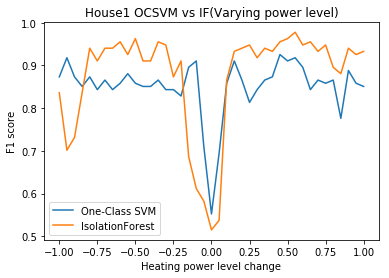

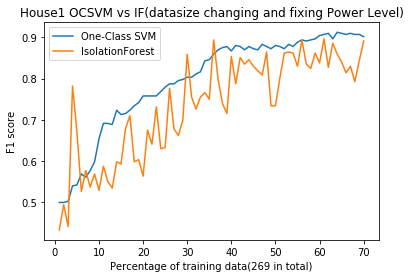

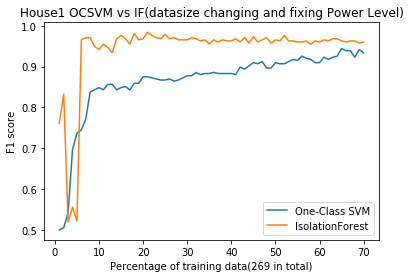

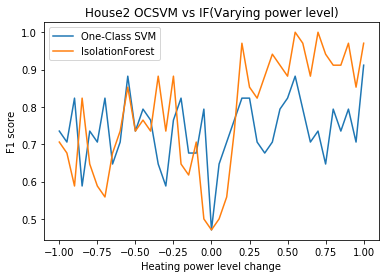

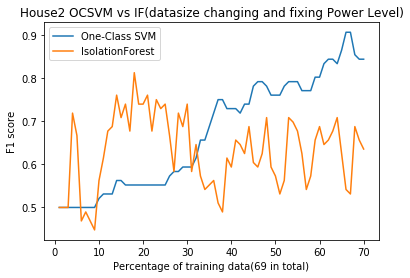

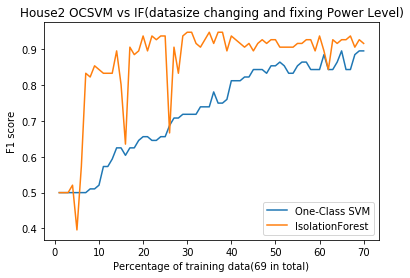

Running time is 464 seconds


In [16]:
stime = datetime.datetime.now() #find out the running time
for l in range(1,22):
    if l==12 or l==14:
        continue
    else:
        app_WM = app["House%d"%l]
        df = df_all["House%d"%l]
        conv_filter = convolution_filter()
        X_normal,X_PL = power_level_change(df,app_WM)
        OCSVM_IF_PLC(X_normal,X_PL,number=l)
        data_size_change(X_normal,X_PL, level=10, number=l, name ='Power Level')
        data_size_change(X_normal,X_PL, level=70, number=l, name ='Power Level')
etime = datetime.datetime.now()
t = (etime-stime).seconds
print('Running time is %d seconds' %(t))